# TP1 

## Question 1
La densité électronique, $n_e$, d'un milieu peut être calculée, selon la formule de Bethe, ainsi: $$n_e=\frac{N_{A}Z \cdot \rho}{M},$$ où $N_A$ est le nombre d'Avogadro, $Z$ est la charge d'une particule ($Z = 1$ pour les protons), $M$ est la masse molaire du milieu ($M = A \cdot M_u$), $A$ est la masse atomique relative et $M_{u}$ la constante de masse molaire ($M_{u} = 1 g/cm^3$). 

Les propriétés des [milieux](www.physics.nist.gov/cgi-bin/Star/compos.pl?ap) et des [éléments](www.ptable.com) les composants sont obtenues à l'aide du site du NSIT et du site Ptable respectivement.

In [1]:
# Propriétés des milieux (eau et os) sous forme de dictionnaire 

import numpy as np

                        # Densité [g/cm^3]
eau_liq = {"Densité" : 1.00000E+00,
                       # Mean Excitation Energy [MeV]
           "MEE" : 75.000000E-06,
                               # numéro atomique
           "Composition" : np.array([[1, 8], 
                                     # proportion dans le milieu
                                     [0.111894, 0.888106], 
                                     # masse molaire [g/mol] (source ptable.com)
                                     [1.008, 15.999]])} 

                        # Densité [g/cm^3]
os_compact = {"Densité" : 1.85000E+00, 
                      # Mean Excitation Energy [MeV]
              "MEE" : 91.900000E-06,
                                              # numéro atomique
              "Composition" : np.array([[1, 6, 7, 8, 12, 15, 16, 20], 
                                                # proportion dans le milieu
                                        [0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000],
                                                        # masse molaire [g/mol] (source ptable.com)
                                        [1.008, 12.011, 14.007, 15.999, 24.305, 30.738, 32.065, 40.078]])} 


In [2]:
# fonction de la densité électronique selon les propriétés du milieu

import scipy.constants as cst

def n_e(num_ato, proportion, mass_mol, densité):
    return cst.Avogadro * densité * np.sum(proportion * num_ato / mass_mol) 

In [3]:
# n_e pour un os compact et l'eau

eau_liq["n_e"] = n_e(num_ato = eau_liq["Composition"][0], proportion = eau_liq["Composition"][1], 
                     mass_mol = eau_liq["Composition"][2], densité = eau_liq["Densité"])

os_compact["n_e"] = n_e(num_ato = os_compact["Composition"][0], proportion = os_compact["Composition"][1], 
                        mass_mol = os_compact["Composition"][2], densité = os_compact["Densité"])

print("Valeur de la densité électronique selon la formule de Bethe \n   Eau liquide : {:.2E} [électrons/cm^3]\n   Os compact : {:.2E} [électrons/cm^3]".format(eau_liq["n_e"], os_compact["n_e"]))

Valeur de la densité électronique selon la formule de Bethe 
   Eau liquide : 3.34E+23 [électrons/cm^3]
   Os compact : 5.91E+23 [électrons/cm^3]


Comme l'application de la protonthérapie produisent des faisceaux de particules dans la gamme 70-250 MeV, soit des protons de plus de 3 MeV, il est possible d'obtenir le pouvoir d'arrêt collisionnel selon l'énergie d'un proton comme suit : 

$$S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2}\left[\ln\left(\frac{2m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right],$$
où $r_e$ est le rayon d'un électron classique, $m_e$ est la masse d'un électron, $c$ est la vitesse de la lumière, $T_e^{max}$ est l'énergie maximale transférable à un électron par le proton, $I$ est l'énergie moyenne d'excitation du matériau et $\beta$ et $\gamma$ sont les facteurs de Lorentz.

In [4]:
# Constantes des protons et électrons

from numpy import sqrt, pi, log

# rayon classique d'un électron [m]
r_e = 2.8179403227E-13     

# énergie de masse d'un électron/c^2 [MeV/(m/s)^2]
m_e_c2 = 0.51099895000

# énergie de masse d'un proton/c^2 [MeV/(m/s)^2]
m_p_c2 = 938.27208816  


# facteur de Lorentz selon l'énergie du proton

def gamma(T):
    return (T/(m_p_c2)) + 1

def beta(T):
    beta = sqrt((gamma(T)**2 - 1) / gamma(T)**2)
    return beta

# Décomposition de Te_max comme les équations (6) de la page 4 de l'énoncé

a = 2 * m_e_c2
b = 1 + (m_e_c2 / m_p_c2)**2
d = 2*(m_e_c2 / m_p_c2)


def Te_max(T):
    return a*(gamma(T)**2 - 1) / (b + d * gamma(T))

In [5]:
# fonction de l'arrêt collisionnel massive pour un proton de plus de 3 MeV
# Pour faciliter la lecture, l'équation Scol est décomposée en variable t1 et t2


def t1(T):
    return 2 * pi * r_e**2 *m_e_c2 / (beta(T)**2)
def t2(T):
    return 2 * m_e_c2 * beta(T)**2 * gamma(T)**2

# Scol varie selon le milieu (eau ou os), en n_e et I. Il varie aussi selon l'énergie du proton T

def Scol(n_e, T, I):
    return t1(T) * n_e * (log(t2(T)*Te_max(T) / I**2) - 2*beta(T)**2)


In [6]:
# valeurs théorique de l'eau

data_water_x = [1.000E-03,1.500E-03,2.000E-03,2.500E-03,3.000E-03,4.000E-03,5.000E-03,6.000E-03,7.000E-03,8.000E-03,9.000E-03,1.000E-02,1.250E-02,1.500E-02,1.750E-02,2.000E-02,2.250E-02,2.500E-02,2.750E-02,3.000E-02,3.500E-02,4.000E-02,4.500E-02,5.000E-02,5.500E-02,6.000E-02,6.500E-02,7.000E-02,7.500E-02,8.000E-02,8.500E-02,9.000E-02,9.500E-02,1.000E-01,1.250E-01,1.500E-01,1.750E-01,2.000E-01,2.250E-01,2.500E-01,2.750E-01,3.000E-01,3.500E-01,4.000E-01,4.500E-01,5.000E-01,5.500E-01,6.000E-01,6.500E-01,7.000E-01,7.500E-01,8.000E-01,8.500E-01,9.000E-01,9.500E-01,1.000E+00,1.250E+00,1.500E+00,1.750E+00,2.000E+00,2.250E+00,2.500E+00,2.750E+00,3.000E+00,3.500E+00,4.000E+00,4.500E+00,5.000E+00,5.500E+00,6.000E+00,6.500E+00,7.000E+00,7.500E+00,8.000E+00,8.500E+00,9.000E+00,9.500E+00,1.000E+01,1.250E+01,1.500E+01,1.750E+01,2.000E+01,2.500E+01,2.750E+01,3.000E+01,3.500E+01,4.000E+01,4.500E+01,5.000E+01,5.500E+01,6.000E+01,6.500E+01,7.000E+01,7.500E+01,8.000E+01,8.500E+01,9.000E+01,9.500E+01,1.000E+02,1.250E+02,1.500E+02,1.750E+02,2.000E+02,2.250E+02,2.500E+02,2.750E+02,3.000E+02,3.500E+02,4.000E+02,4.500E+02,5.000E+02,5.500E+02,6.000E+02,6.500E+02,7.000E+02,7.500E+02,8.000E+02,8.500E+02,9.000E+02,9.500E+02,1.000E+03,1.500E+03,2.000E+03,2.500E+03,3.000E+03,4.000E+03,5.000E+03,6.000E+03,7.000E+03,8.000E+03,9.000E+03,1.000E+04]
data_water_y = [1.769E+02,1.984E+02,2.184E+02,2.370E+02,2.544E+02,2.864E+02,3.153E+02,3.420E+02,3.667E+02,3.900E+02,4.120E+02,4.329E+02,4.745E+02,5.110E+02,5.437E+02,5.733E+02,6.001E+02,6.245E+02,6.467E+02,6.671E+02,7.028E+02,7.324E+02,7.569E+02,7.768E+02,7.927E+02,8.050E+02,8.142E+02,8.205E+02,8.243E+02,8.260E+02,8.258E+02,8.239E+02,8.206E+02,8.161E+02,7.814E+02,7.371E+02,6.969E+02,6.613E+02,6.294E+02,6.006E+02,5.744E+02,5.504E+02,5.080E+02,4.719E+02,4.406E+02,4.132E+02,3.891E+02,3.680E+02,3.492E+02,3.325E+02,3.175E+02,3.039E+02,2.917E+02,2.805E+02,2.702E+02,2.608E+02,2.229E+02,1.957E+02,1.749E+02,1.586E+02,1.454E+02,1.344E+02,1.251E+02,1.172E+02,1.042E+02,9.404E+01,8.586E+01,7.911E+01,7.343E+01,6.858E+01,6.438E+01,6.071E+01,5.747E+01,5.460E+01,5.202E+01,4.969E+01,4.759E+01,4.567E+01,3.815E+01,3.292E+01,2.905E+01,2.607E+01,2.175E+01,2.013E+01,1.876E+01,1.656E+01,1.488E+01,1.354E+01,1.245E+01,1.154E+01,1.078E+01,1.013E+01,9.559E+00,9.063E+00,8.625E+00,8.236E+00,7.888E+00,7.573E+00,7.289E+00,6.192E+00,5.445E+00,4.903E+00,4.492E+00,4.170E+00,3.911E+00,3.698E+00,3.520E+00,3.241E+00,3.032E+00,2.871E+00,2.743E+00,2.640E+00,2.556E+00,2.485E+00,2.426E+00,2.376E+00,2.333E+00,2.296E+00,2.264E+00,2.236E+00,2.211E+00,2.070E+00,2.021E+00,2.004E+00,2.001E+00,2.012E+00,2.031E+00,2.052E+00,2.072E+00,2.091E+00,2.109E+00,2.126E+00]

# valeurs théorique de l'os compact

data_bone_x = [1.000E-03,1.500E-03,2.000E-03,2.500E-03,3.000E-03,4.000E-03,5.000E-03,6.000E-03,7.000E-03,8.000E-03,9.000E-03,1.000E-02,1.250E-02,1.500E-02,1.750E-02,2.000E-02,2.250E-02,2.500E-02,2.750E-02,3.000E-02,3.500E-02,4.000E-02,4.500E-02,5.000E-02,5.500E-02,6.000E-02,6.500E-02,7.000E-02,7.500E-02,8.000E-02,8.500E-02,9.000E-02,9.500E-02,1.000E-01,1.250E-01,1.500E-01,1.750E-01,2.000E-01,2.250E-01,2.500E-01,2.750E-01,3.000E-01,3.500E-01,4.000E-01,4.500E-01,5.000E-01,5.500E-01,6.000E-01,6.500E-01,7.000E-01,7.500E-01,8.000E-01,8.500E-01,9.000E-01,9.500E-01,1.000E+00,1.250E+00,1.500E+00,1.750E+00,2.000E+00,2.250E+00,2.500E+00,2.750E+00,3.000E+00,3.500E+00,4.000E+00,4.500E+00,5.000E+00,5.500E+00,6.000E+00,6.500E+00,7.000E+00,7.500E+00,8.000E+00,8.500E+00,9.000E+00,9.500E+00,1.000E+01,1.250E+01,1.500E+01,1.750E+01,2.000E+01,2.500E+01,2.750E+01,3.000E+01,3.500E+01,4.000E+01,4.500E+01,5.000E+01,5.500E+01,6.000E+01,6.500E+01,7.000E+01,7.500E+01,8.000E+01,8.500E+01,9.000E+01,9.500E+01,1.000E+02,1.250E+02,1.500E+02,1.750E+02,2.000E+02,2.250E+02,2.500E+02,2.750E+02,3.000E+02,3.500E+02,4.000E+02,4.500E+02,5.000E+02,5.500E+02,6.000E+02,6.500E+02,7.000E+02,7.500E+02,8.000E+02,8.500E+02,9.000E+02,9.500E+02,1.000E+03,1.500E+03,2.000E+03,2.500E+03,3.000E+03,4.000E+03,5.000E+03,6.000E+03,7.000E+03,8.000E+03,9.000E+03,1.000E+04]
data_bone_y = [1.738E+02,1.997E+02,2.227E+02,2.436E+02,2.629E+02,2.962E+02,3.262E+02,3.537E+02,3.791E+02,4.025E+02,4.243E+02,4.449E+02,4.859E+02,5.212E+02,5.523E+02,5.802E+02,6.051E+02,6.275E+02,6.476E+02,6.657E+02,6.974E+02,7.239E+02,7.457E+02,7.633E+02,7.770E+02,7.872E+02,7.946E+02,7.994E+02,8.020E+02,8.027E+02,8.018E+02,7.994E+02,7.958E+02,7.912E+02,7.575E+02,7.154E+02,6.722E+02,6.312E+02,5.939E+02,5.604E+02,5.306E+02,5.041E+02,4.595E+02,4.234E+02,3.937E+02,3.687E+02,3.472E+02,3.284E+02,3.119E+02,2.972E+02,2.840E+02,2.720E+02,2.612E+02,2.513E+02,2.422E+02,2.339E+02,2.005E+02,1.764E+02,1.581E+02,1.436E+02,1.318E+02,1.220E+02,1.137E+02,1.065E+02,9.490E+01,8.576E+01,7.838E+01,7.228E+01,6.715E+01,6.276E+01,5.896E+01,5.563E+01,5.269E+01,5.008E+01,4.774E+01,4.562E+01,4.371E+01,4.196E+01,3.511E+01,3.033E+01,2.679E+01,2.406E+01,2.010E+01,1.861E+01,1.736E+01,1.534E+01,1.378E+01,1.255E+01,1.155E+01,1.071E+01,1.001E+01,9.401E+00,8.878E+00,8.420E+00,8.015E+00,7.655E+00,7.332E+00,7.042E+00,6.778E+00,5.762E+00,5.070E+00,4.567E+00,4.186E+00,3.887E+00,3.646E+00,3.449E+00,3.284E+00,3.024E+00,2.830E+00,2.681E+00,2.562E+00,2.466E+00,2.386E+00,2.318E+00,2.261E+00,2.213E+00,2.171E+00,2.135E+00,2.103E+00,2.076E+00,2.052E+00,1.916E+00,1.869E+00,1.854E+00,1.852E+00,1.865E+00,1.885E+00,1.907E+00,1.927E+00,1.947E+00,1.965E+00,1.982E+00]


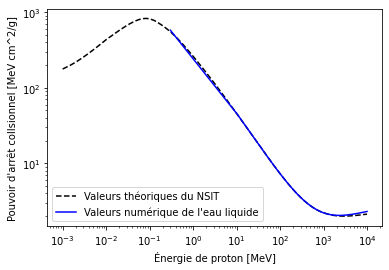

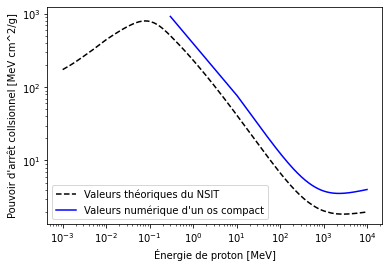

In [7]:
# Présentation des courbes

from numpy import linspace, loadtxt
from math import exp
import matplotlib.pylab as plt

##### eau liquide #####

# data_water = loadtxt("Scol_water.txt",float)  

xpoints_w = linspace(0.3, 10000, 1000)
ypoints_w = []

#Les propriétés sont reprises dans les dictionnaires du premier block.

for T in xpoints_w:
    ypoints_w.append(Scol(eau_liq["n_e"], T, eau_liq["MEE"]))

plt.plot(data_water_x, data_water_y, "k--", label="Valeurs théoriques du NSIT")
plt.plot(xpoints_w, ypoints_w,"b", label="Valeurs numérique de l'eau liquide")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie de proton [MeV]")
plt.ylabel("Pouvoir d'arrêt collsionnel [MeV cm^2/g]")
plt.legend()
plt.show()


##### os compact ######

#data_bone = loadtxt("Scol_bone.txt",float)

xpoints_b = linspace(0.3, 10000, 1000)
ypoints_b = []

for T in xpoints_b:
    ypoints_b.append(Scol(os_compact["n_e"], T, os_compact["MEE"]))


plt.plot(data_bone_x, data_bone_y, "k--", label="Valeurs théoriques du NSIT")
plt.plot(xpoints_b, ypoints_b,"b", label="Valeurs numérique d'un os compact")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie de proton [MeV]")
plt.ylabel("Pouvoir d'arrêt collsionnel [MeV cm^2/g]")
plt.legend()
plt.show()



# Question 2
L'homogénité dimensionnelle peut être vérifiée lorsque de deux grandeurs s'expriment dans la même unité. On souhaite vérifier l'homognéité de $R_{CSDA}$ qui est définiepar l'équation suivante: $$R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{\frac{S_{c o l}}{\rho}}.$$ Sachant que $R_{C S D A}$ représente la porté des protons dans un milieu, elle doit donc être exprimé en unité longueur. On souhaite donc que le côté gauche de l'équation soit réductible à une unité de longueur. L'énergie $T$ est exprimée en $[M L^2 T^{-2}]$, le pouvoir colisonniel, $S_{col}$, en $[M L T^{-2}]$ et finalement, $\rho$, en $[M L^{-3}]$. En remplaçant dans l'équation, on obtient: $$\frac{[M L^2 T^{-2}][M L^{-3}]}{[M L T^{-2}]} = \left[\frac{M}{L^2}\right].$$ Le côté droite de l'équation n'est pas exprimé dans la même unité que le côté gauche, cela réfute l'homogénité dimensionnelle de $R_{CSDA}$.

# Question 3
Non, lorsqu'on regarde le graphique (Faire un graph avec les données du NIST) ci-dessous avec l'eau on s'apperçoit que la contribution de la radiation est très faible comparativement au stoppage électronnique. On obtient un résultat où les contributions nucléaires ont encore moins d'impact avec les os compacts.  

# Question 4
Une raison qui justifie l'emploi de méthode numérique est le fait que l'intégration de la fonction $1/S_{col}(T)$ ne donne pas une fonction formé de fonctions élémentaires. En effet, lorsqu'on passe l'équation dans une algorithme ayant pour but de vérifier si la solution de l'intégrale est formée de fonctions élementaires, comme l'algorithme de Risch, celui-ci ne donne pas une solution. Il est donc plus simple d'évaluer l'intégrale numériquement.  


# Question 5

# Question 6
Mettre l'équation 